## Import Library

In [80]:
import json
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from nltk_utils import tokenize, stem, bag_of_words
from model import create_model
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout

## Define Variables

In [81]:
PATH_INTENTS = '../../data/intents.json'
PATH_MODEL = 'chat_model.h5'
PATH_METADATA = 'metadata.json'

In [82]:
# Define lists
all_words = []  # Words in the patterns
tags = []       # Tags of sentences
xy = []         # (Pattern sentence, Tag) pairs

## Load Data

In [83]:
# Open file json
with open(PATH_INTENTS, 'r') as f:
    intents = json.load(f)

## Data Preparation

In [84]:
# Process each intent
for intent in intents['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w, tag))

In [85]:
xy[:5]

[(['Hi'], 'greeting'),
 (['Hey'], 'greeting'),
 (['Is', 'anyone', 'there', '?'], 'greeting'),
 (['Hi', 'there'], 'greeting'),
 (['Hello'], 'greeting')]

In [86]:
# Stemming
ignore_words = ['?', '!', '.', ',']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

In [87]:
all_words[-5:]

['ye', 'yeah', 'you', 'your', 'yourself']

In [88]:
tags[:5]

['about', 'afternoon', 'anxious', 'ask', 'casual']

In [89]:
# Create training data
x_train = []
y_train = []
for (pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    x_train.append(bag)
    y_train.append(tag)

In [90]:
# Convert to numpy arrays
x_train = np.array(x_train)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=len(tags))

In [91]:
# Mengubah ukuran data menjadi ukuran yang diterima oleh LTSM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

## Modeling

In [92]:
# Define hyperparameters
input_size = len(x_train[0])
hidden_size = 8
output_size = len(tags)
learning_rate = 0.001
num_epochs = 100
batch_size = 32

In [93]:
output_size

80

In [94]:
# Create the model
# model = models.Sequential()
# model.add(layers.Input(shape=(input_size,)))
# model.add(layers.Dense(64))
# model.add(layers.Dense(32))
# model.add(layers.Dense(16))
# model.add(layers.Dense(hidden_size))
# model.add(layers.Dense(output_size, activation='softmax'))

In [95]:
len(xy)

232

In [96]:
input_size

279

In [97]:
x_train.shape

(232, 279, 1)

In [98]:
y_train.shape

(232, 80)

In [99]:
model = Sequential()
model.add(layers.Input(shape=(input_size,1)))
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32))
model.add(LayerNormalization())
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(output_size, activation="softmax"))

In [100]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [101]:
# Train the model
# model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1)
history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, verbose=1, validation_split=0.1)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 25s 765ms/step - accuracy: 0.0080 - loss: 5.0724 - val_accuracy: 0.0000e+00 - val_loss: 5.1988
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 0.0486 - loss: 4.3630 - val_accuracy: 0.0000e+00 - val_loss: 5.4922
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.0421 - loss: 4.0108 - val_accuracy: 0.0000e+00 - val_loss: 5.8030
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.0645 - loss: 3.9732 - val_accuracy: 0.0000e+00 - val_loss: 6.0362
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 336ms/step - accuracy: 0.0616 - loss: 3.7967 - val_accuracy: 0.0000e+00 - val_loss: 6.1475
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - accuracy: 0.1206 - loss: 3.4883 - val_accuracy: 0.0000e+00 - val_loss: 6.1956
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.1317 - loss: 3.5291 - val_accuracy: 0.0000e+00 - val_loss: 6.3380
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.1255 - loss: 3.36

In [103]:
import matplotlib.pyplot as plt


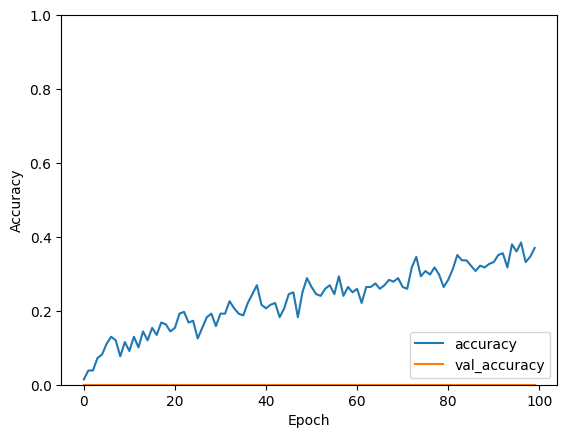

In [104]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

## Export

In [105]:
# Save model and metadata
model.save(PATH_MODEL)
metadata = {
    'input_size': input_size,
    'output_size': output_size,
    'hidden_size': hidden_size,
    'all_words': all_words,
    'tags': tags,
    'label_encoder_classes': label_encoder.classes_.tolist()
}

with open(PATH_METADATA, 'w') as f:
    json.dump(metadata, f)
print('Training complete. Model and metadata saved.')

Training complete. Model and metadata saved.
